# Missing values
this section looks at the diffrent misisng values in our dataset

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import xyzservices.providers as xyz
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import KBinsDiscretizer
import statistics as stat

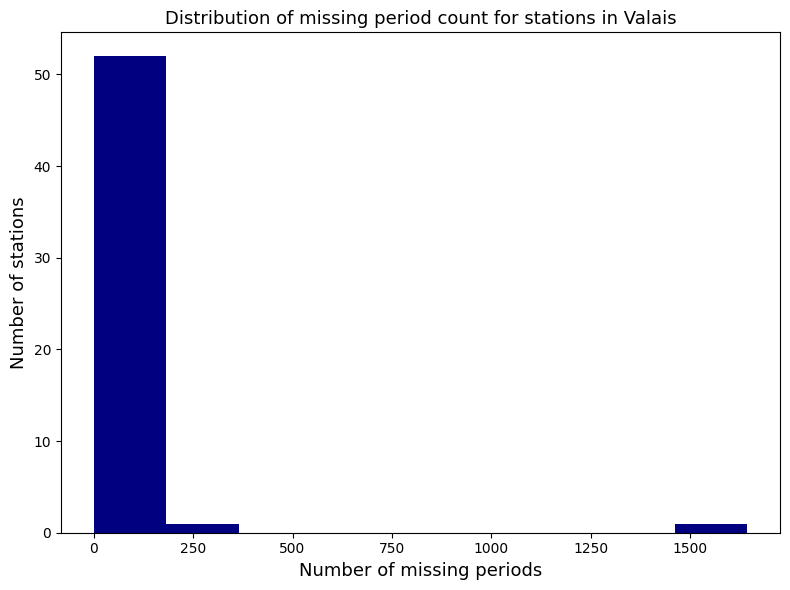

In [11]:
miss_df = pd.read_csv('../../data/combined_missing_data.csv')
station_list = pd.read_csv('../../data/clean/valais_stations.csv')

station_count = miss_df[['station']].value_counts(dropna=False).reset_index()
station_count.columns = ['station', 'missing_count']

merged_df = station_list.merge(station_count, how='left', on='station')
merged_df['missing_count'] = merged_df['missing_count'].fillna(0)
#create plot
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(merged_df['missing_count'],bins=9, color='navy')

ax.set_title('Distribution of missing period count for stations in Valais', fontsize=13)
ax.set_xlabel('Number of missing periods', fontsize=13)
ax.set_ylabel('Number of stations', fontsize=13)

plt.tight_layout()
plt.savefig('../../report/figures/missing/missing_count_bars.pdf')
plt.show()

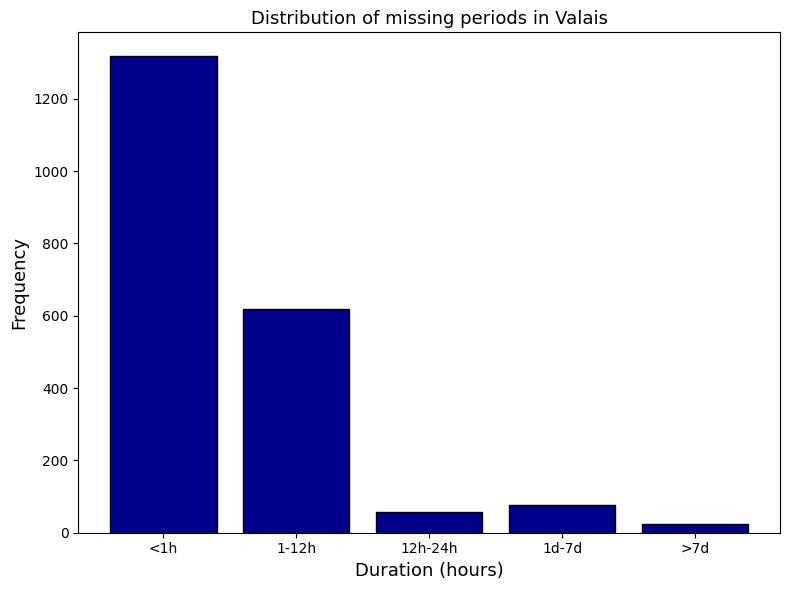

In [12]:
miss_df = pd.read_csv('../../data/combined_missing_data.csv')
station_list = pd.read_csv('../../data/clean/valais_stations.csv')
miss_df = miss_df[miss_df['station'].isin(station_list['station'])]
missing_durations = miss_df['missing_duration']

# Define bins and labels
bins = [0, 6, 72, 144, 1008, float("inf")]
labels = ["<1h", "1-12h", "12h-24h", "1d-7d", ">7d"]

binned_labels = pd.cut(missing_durations, bins=bins, labels=labels)

category_counts = pd.Series(binned_labels).value_counts().reindex(labels, fill_value=0)

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(category_counts.index, category_counts.values,
        color='darkblue',
        edgecolor='black')

ax.set_title('Distribution of missing periods in Valais', fontsize=13)
ax.set_xlabel('Duration (hours)', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)

plt.tight_layout()
plt.show()

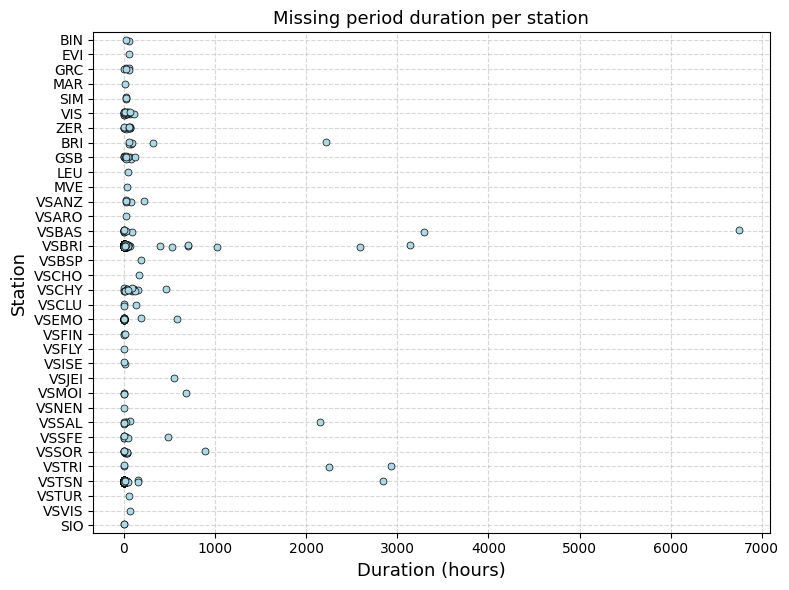

In [16]:
miss_df = pd.read_csv('../../data/combined_missing_data.csv')
station_list = pd.read_csv('../../data/clean/valais_stations.csv')
miss_df = miss_df[miss_df['station'].isin(station_list['station'])]

#station_counts = miss_df['station'].value_counts()
#stations_over_10 = station_counts[station_counts > 10].index
miss_df['hours'] = miss_df['missing_duration']/6

fig, ax = plt.subplots(figsize=(8,6))

sns.stripplot(x='hours', y='station', data=miss_df,
            facecolors='lightblue', edgecolor='black', linewidth=0.5)

ax.set_title('Missing period duration per station', fontsize=13)
ax.set_ylabel('Station', fontsize=13)
ax.set_xlabel('Duration (hours)', fontsize=13)

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig('../../report/figures/missing/missing_duration_strip.pdf')
plt.show()

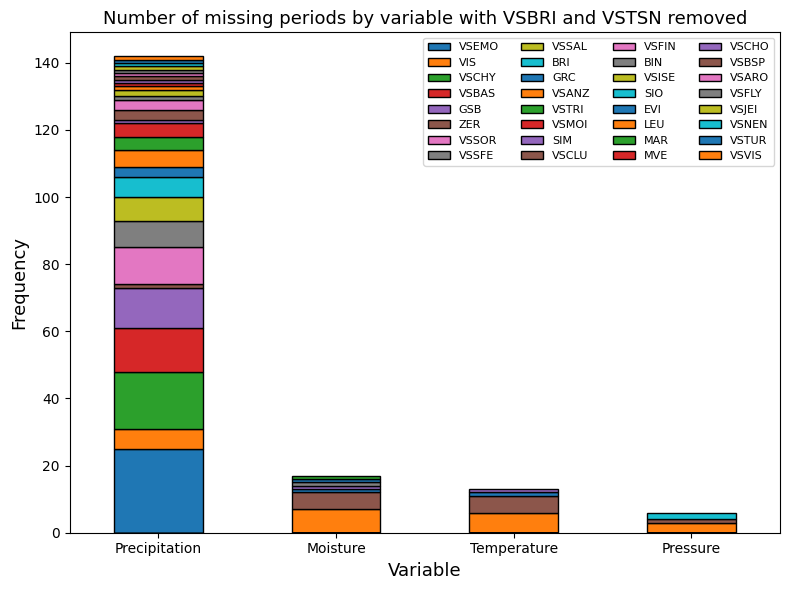

In [19]:
miss_df = pd.read_csv('../../data/combined_missing_data.csv')
station_list = pd.read_csv('../../data/clean/valais_stations.csv')
miss_df = miss_df[miss_df['station'].isin(station_list['station'])]
miss_df = miss_df[~miss_df['station'].isin(['VSBRI', 'VSTSN'])]

vars_counts = miss_df.groupby(['variable', 'station']).size().unstack(fill_value=0)

vars_counts['total'] = vars_counts.sum(axis=1)
vars_counts = vars_counts.sort_values('total', ascending=False)
vars_counts = vars_counts.drop(columns='total')

# Sort stations by total count across all variables (descending)
station_totals = vars_counts.sum(axis=0).sort_values(ascending=False)
vars_counts = vars_counts[station_totals.index]

fig, ax = plt.subplots(figsize=(8,6))
vars_counts.plot(kind='bar', stacked=True, ax=ax, edgecolor='black')

# Example custom labels
varlist = ['Precipitation', 'Moisture', 'Temperature', 'Pressure']
# Replace x-axis labels
ax.set_xticks(range(len(varlist)))
ax.set_xticklabels(varlist, rotation=0, ha='center') 

# Titles and labels
ax.set_title('Number of missing periods by variable with VSBRI and VSTSN removed', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)
ax.set_xlabel('Variable', fontsize=13)
ax.legend(loc="upper right", fontsize=8, ncols=4)

# Layout and save
plt.tight_layout()
plt.savefig('../../report/figures/missing/valais/variable_histogram_stacked_filter.pdf')
plt.show()